# Statical Methods: Chi-Square, ANNOVA and Regression Analysis.

In [227]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.gofplots as gof
from scipy.stats import chi2_contingency, chisquare
from statsmodels.formula.api import ols
from statsmodels.stats import outliers_influence as sm_oi
from statsmodels.stats.anova import anova_lm

warnings.filterwarnings("ignore")
sns.set_theme("notebook", "whitegrid")

## Custom Functions

In [228]:
def custom_statsmodel_OLS(_DF, *vars):
    """fitting OLS on specified independent and dependent variables- DF, dependent_var and independent_var"""
    # sm.add_constant
    try:
        LOS_COLS = [v for v in vars]
        _X = LOS_COLS[1:]
        _Y = LOS_COLS[0]
        xvars = sm.add_constant(_DF[_X])
        yvar = _DF[_Y]
        _model_spec = sm.OLS(yvar, xvars)
        return _model_spec
    except Exception as e:
        print(f"There is an error while creating a model spec due to:{e}")


def custom_model_preds(_model, _new_df):
    """Predictions on new data points"""
    _feat = sm.add_constant(_new_df)
    _pred = _model.predict(sm.add_constant(_feat))
    _df_pred = pd.DataFrame(_pred)
    _df_pred.columns = ["predicted_y"]
    return _df_pred


def custom_VIF(_MSPEC):
    """Custom function to get the VIF"""
    var_names = _MSPEC.exog_names
    X = _MSPEC.exog
    _limit = X.shape[1]
    try:
        vif_dict = {}
        for idx in range(_limit):
            vif = round(sm_oi.variance_inflation_factor(X, idx), 5)
            vif_dict[var_names[idx]] = vif
        _DF = pd.DataFrame([vif_dict]).T
        _DF.columns = ["VIF"]
        _DF = _DF.reset_index()
        df_sorted = _DF.iloc[1:].sort_values(by="VIF", ascending=False)
        ax = sns.barplot(x="index", y="VIF", data=df_sorted)
        # Add text labels to the top of each bar
        for bar in ax.containers[0]:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                int(bar.get_height()),
                ha="center",
                va="bottom",
            )
        ax.set_xlabel("FIELD")
        ax.set_ylabel("VIF")
        plt.xticks(rotation=45)
        plt.title("VIF")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass


def custom_ols_qqplot(_resid):
    """Q-Q Plot of residuals"""
    gof.qqplot(_resid, line="s")
    plt.xlabel("Standard Normal Quantiles")
    plt.ylabel("Standardized Residuals")
    plt.title("Normal Q-Q plot")
    plt.show()


def custom_ols_res_vs_fitted(_fitted, _resid):
    """Fitted Vs Residuals Plot"""
    plt.scatter(_fitted, _resid)
    plt.axhline("0", color="r")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residual")
    plt.title("Residual Vs Fitted")

## Chi-Square and Annova- Cases

In [229]:
# Importing data
df_ecom = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/ecom.xlsx"
)
df_smoke = pd.read_csv(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/smoking.csv"
)
df_health = pd.read_excel(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/HealthStats_SSBB.xlsx"
)

In [230]:
df_ecom.head()

,Gender,Age,Overall Use_Level,Amazon_Level,Flipkart_Level,Swiggy_Level,Zomato_Level,Others_Level,Overall CS_Rating,Overall CS_Level
0,Male,34,Medium,High,Medium,Medium,Medium,Low,7,Medium
1,Male,33,High,High,Low,Medium,Medium,Medium,9,High
2,Female,34,High,High,Low,Low,Low,Medium,8,Medium
3,Male,32,Low,Medium,Medium,Low,Medium,Low,8,Medium
4,Female,40,Low,Low,Medium,Low,Low,Low,7,Low


In [231]:
df_health.head()

,Participant No.,Data Segment,Industry,Stress-Per,Stress-Pro,Activity_Level,Age,Sex,Height_cm,Weight_Kg,...,BMI,BMI-Category,Body-Fat,Body Fat Level,Body-Age,Body Age Level,Body Age Level.1,Cal-K,Happiness-Index,Happiness-Index-State
0,1,Group-1,ITES,Medium,High,High,30,F,148.0,51.5,...,23.5,Normal,31.2,High,37.0,7.0,Normal,1132.0,49,Happy
1,2,Group-1,Mfg & Process,Low,High,Medium,40,M,163.0,79.4,...,29.9,High,31.8,High,56.0,16.0,Above,1698.0,36,Happy
2,3,Group-1,ITES,Medium,Medium,High,42,F,143.5,59.7,...,28.8,High,36.5,High,55.0,13.0,Above,1232.0,24,Happy
3,4,Group-1,ITES,Medium,Medium,High,34,M,170.0,78.4,...,27.1,High,26.6,Normal,47.0,13.0,Above,1718.0,47,Happy
4,5,Group-1,Mfg & Process,Low,Medium,High,31,M,170.0,96.2,...,33.3,Obese,29.6,Normal,55.0,24.0,Above,1987.0,38,Happy


In [232]:
df_ecom_sel = df_ecom[["Overall Use_Level", "Overall CS_Level"]]

#### Experiment 1

**Hypothesis**

            Ho: There is no association between Overall Usage and Customer CS Score(Independent)
            Ha: There is an association between Overall Usage and Customer CS Score(Dependent)

In [233]:
df_ecom_CT = (
    pd.crosstab(df_ecom_sel["Overall Use_Level"], df_ecom_sel["Overall CS_Level"])
    .reset_index()
    .drop(["Overall Use_Level"], axis=1)
)

CS_LVEL = df_ecom_CT.to_numpy()

In [234]:
_chi2, _pvalue, _ddof, _expected = chi2_contingency(CS_LVEL)

In [235]:
print(
    f"P-Value Caluclated is:{round(_pvalue,3)} which is lesser than to 0.05, hence we can reject the null hypothesis, degrees of freedom:{_ddof} and chi-square stat:{round(_chi2,5)}"
)

P-Value Caluclated is:0.041 which is lesser than to 0.05, hence we can reject the null hypothesis, degrees of freedom:4 and chi-square stat:9.96292


#### Experiment 2:

**Hypothesis**

            Ho: There is no association between Maritual Status and Smoking
            Ha: There is an association between Maritual Status and Smoking

**Hypothesis**

            Ho: There is no association between Gender and Smoking
            Ha: There is an association between Gender and Smoking

In [236]:
df_smoke_tidy = df_smoke[["marital_status", "smoke"]]
df_gender_tidy = df_smoke[["gender", "smoke"]]
df_smoke_CT = (
    pd.crosstab(df_smoke_tidy["marital_status"], df_smoke_tidy["smoke"])
    .reset_index()
    .drop(["marital_status"], axis=1)
)
df_gender_CT = (
    pd.crosstab(df_gender_tidy["gender"], df_gender_tidy["smoke"])
    .reset_index()
    .drop(["gender"], axis=1)
)
smoke_NUM = df_smoke_CT.to_numpy()
gender_NUM = df_gender_CT.to_numpy()

In [237]:
# ChiSquare ex1
_chi2, _pvalue, _ddof, _expected = chi2_contingency(smoke_NUM)

In [238]:
print(
    f"P-Value Caluclated is:{round(_pvalue,3)} which is lesser than to 0.05, hence we can reject the null hypothesis, degrees of freedom:{_ddof} and chi-square stat:{round(_chi2,5)}"
)

P-Value Caluclated is:0.0 which is lesser than to 0.05, hence we can reject the null hypothesis, degrees of freedom:4 and chi-square stat:74.97979


In [239]:
# ChiSquare ex2
_chi2, _pvalue, _ddof, _expected = chi2_contingency(gender_NUM)

In [240]:
print(
    f"P-Value Caluclated is:{round(_pvalue,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis, degrees of freedom:{_ddof} and chi-square stat:{round(_chi2,5)}"
)

P-Value Caluclated is:0.513 which is greater than to 0.05, hence we failed to reject the null hypothesis, degrees of freedom:1 and chi-square stat:0.42699


#### Experiment 3

**Hypothesis**

            Ho: There is no association between Industry and HappyNess Index
            Ha: There is an association between Industry and HappyNess Index

In [241]:
df_health_CT = (
    pd.crosstab(df_health["Industry"], df_health["Happiness-Index-State"])
    .reset_index()
    .drop(["Industry"], axis=1)
)

health_NUM = df_health_CT.to_numpy()

In [242]:
# ChiSquare ex2
_chi2, _pvalue, _ddof, _expected = chi2_contingency(health_NUM)

In [243]:
print(
    f"P-Value Caluclated is:{round(_pvalue,3)} which is greater than to 0.05, hence we failed to reject the null hypothesis, degrees of freedom:{_ddof} and chi-square stat:{round(_chi2,5)}"
)

P-Value Caluclated is:0.08 which is greater than to 0.05, hence we failed to reject the null hypothesis, degrees of freedom:2 and chi-square stat:5.05299


**Conclusions**

1) There is an association between Maritual Status and Smoking

2) There is no association between Gender and Smoking

3) There is no association between Industry and HappyNess Index

#### Experiment 4:

**Hypothesis**

            Ho: The average age of all marital status are equal
            Ha: The average age of all marital status are not equal

**Hypothesis**

            Ho: The average age of all usage level customers are equal
            Ha: The average age of all usage level customers are not equal
            
**Hypothesis**

            Ho: The average BMI of All industry participants are equal
            Ha: The average BMI of All industry participants are not equal

In [244]:
df_msage = df_smoke[["marital_status", "age"]]

# Define the model formula
model_1 = ols("age ~ marital_status", data=df_msage).fit()

# Perform ANOVA
anova_table_ex1 = anova_lm(model_1)

# Print ANOVA results
print(anova_table_ex1)

                    df         sum_sq       mean_sq           F         PR(>F)
marital_status     4.0  234048.777309  58512.194327  274.597439  7.189135e-182
Residual        1686.0  359258.847765    213.083540         NaN            NaN


In [245]:
print(
    f"P-Value Caluclated is:{round(anova_table_ex1['PR(>F)'][0],3)} which is lesser than to 0.05, hence we can reject the null hypothesis"
)

P-Value Caluclated is:0.0 which is lesser than to 0.05, hence we can reject the null hypothesis


In [246]:
df_cs = df_ecom[["Overall Use_Level", "Age"]]
df_cs.columns = ["usage", "age"]

# Define the model formula
model_2 = ols("age ~ usage", data=df_cs).fit()

# Perform ANOVA
anova_table_ex2 = anova_lm(model_2)

# Print ANOVA results
print(anova_table_ex2)

            df       sum_sq    mean_sq        F    PR(>F)
usage      2.0    23.580519  11.790260  0.17447  0.840748
Residual  30.0  2027.328571  67.577619      NaN       NaN


In [247]:
print(
    f"P-Value Caluclated is:{round(anova_table_ex2['PR(>F)'][0],3)} which is greater than to 0.05, hence we failed to reject the null hypothesis"
)

P-Value Caluclated is:0.841 which is greater than to 0.05, hence we failed to reject the null hypothesis


In [248]:
df_h = df_health[["Industry", "BMI"]]

# Define the model formula
model_3 = ols("BMI ~ Industry", data=df_h).fit()

# Perform ANOVA
anova_table_ex3 = anova_lm(model_3)

# Print ANOVA results
print(anova_table_ex3)

             df       sum_sq    mean_sq         F    PR(>F)
Industry    2.0   173.765060  86.882530  5.370873  0.005568
Residual  153.0  2475.021863  16.176613       NaN       NaN


In [249]:
print(
    f"P-Value Caluclated is:{round(anova_table_ex3['PR(>F)'][0],3)} which is lesser than to 0.05, hence we reject the null hypothesis"
)

P-Value Caluclated is:0.006 which is lesser than to 0.05, hence we reject the null hypothesis


**Conclusions**

1) The average age of all usage level customers are equal

2) The average age of all marital status are not equal

3) The average BMI of All industry participants are not equal

## Linear Regression Analysis - Cases

### Case 1: BikeShare

#### Data Importing and Data Preparation

In [250]:
df_dcbikes = pd.read_csv(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/dcbikeshares.csv"
)

In [251]:
df_dcbikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [252]:
df_dcbikes_tidy = df_dcbikes[
    [
        "season",
        "holiday",
        "workingday",
        "weathersit",
        "temp",
        "atemp",
        "hum",
        "windspeed",
        "casual",
        "registered",
        "cnt",
    ]
]

In [253]:
df_dcbikes_tidy.head()

,season,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


**EDA 1: Visualize the distribution of daily bike rentals and temperature as well as the relationship between these two variables.**

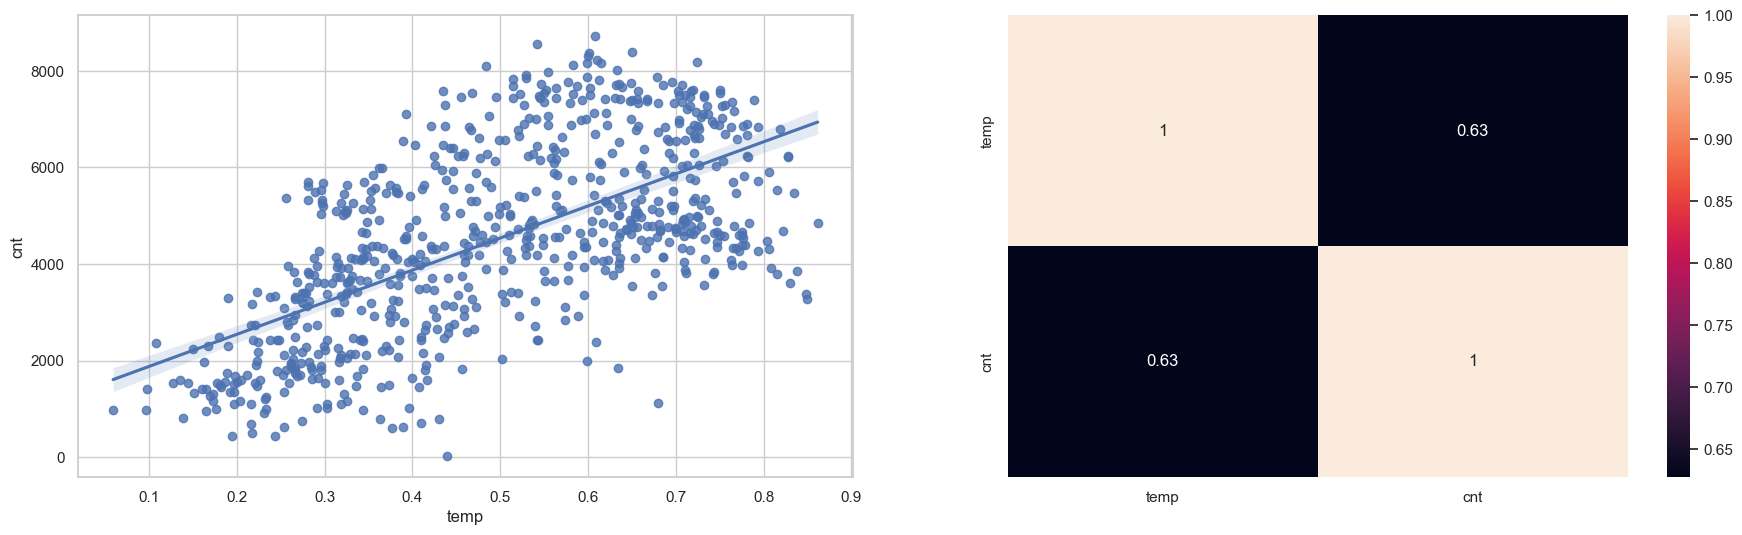

In [254]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))
v1 = sns.regplot(x="temp", y="cnt", data=df_dcbikes_tidy, ax=ax1)
v2 = sns.heatmap(df_dcbikes_tidy[["temp", "cnt"]].corr(), annot=True, ax=ax2)
plt.show()

**EDA2: Visualize the distribution of daily bike rentals and temperature per season**

In [255]:
df_eda2 = df_dcbikes_tidy[["season", "temp", "cnt"]]

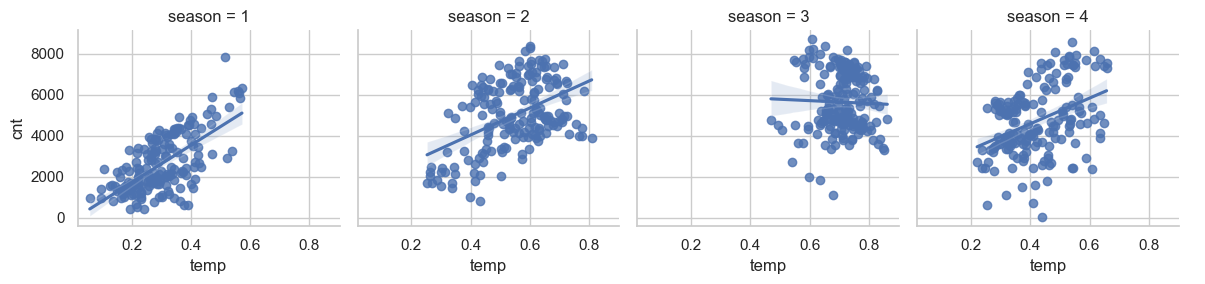

In [256]:
vis_season_grid = sns.FacetGrid(df_dcbikes_tidy, col="season")
vis_season_grid.map_dataframe(sns.regplot, x="temp", y="cnt")
vis_season_grid.add_legend()
plt.show()

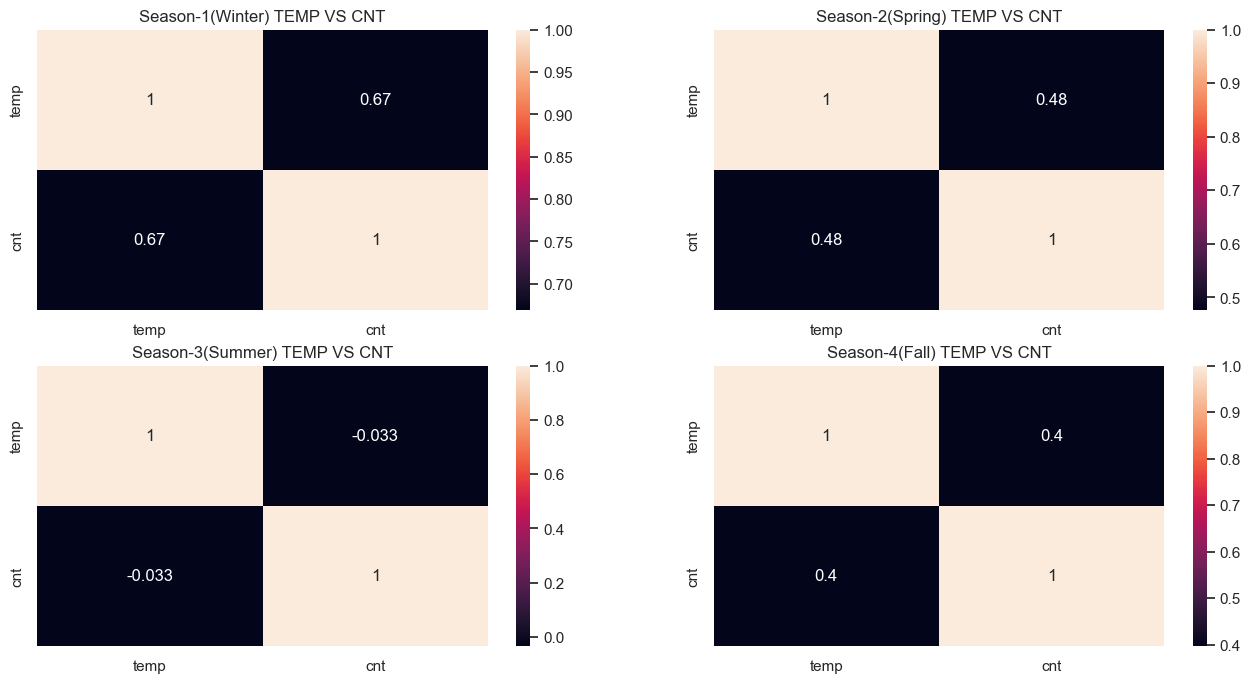

In [257]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
v1 = sns.heatmap(
    df_eda2.loc[df_eda2["season"] == 1, ["temp", "cnt"]].corr(),
    annot=True,
    ax=axes[0, 0],
)
v2 = sns.heatmap(
    df_eda2.loc[df_eda2["season"] == 2, ["temp", "cnt"]].corr(),
    annot=True,
    ax=axes[0, 1],
)
v3 = sns.heatmap(
    df_eda2.loc[df_eda2["season"] == 3, ["temp", "cnt"]].corr(),
    annot=True,
    ax=axes[1, 0],
)
v4 = sns.heatmap(
    df_eda2.loc[df_eda2["season"] == 4, ["temp", "cnt"]].corr(),
    annot=True,
    ax=axes[1, 1],
)
v1.set_title("Season-1(Winter) TEMP VS CNT")
v2.set_title("Season-2(Spring) TEMP VS CNT")
v3.set_title("Season-3(Summer) TEMP VS CNT")
v4.set_title("Season-4(Fall) TEMP VS CNT")
plt.show()

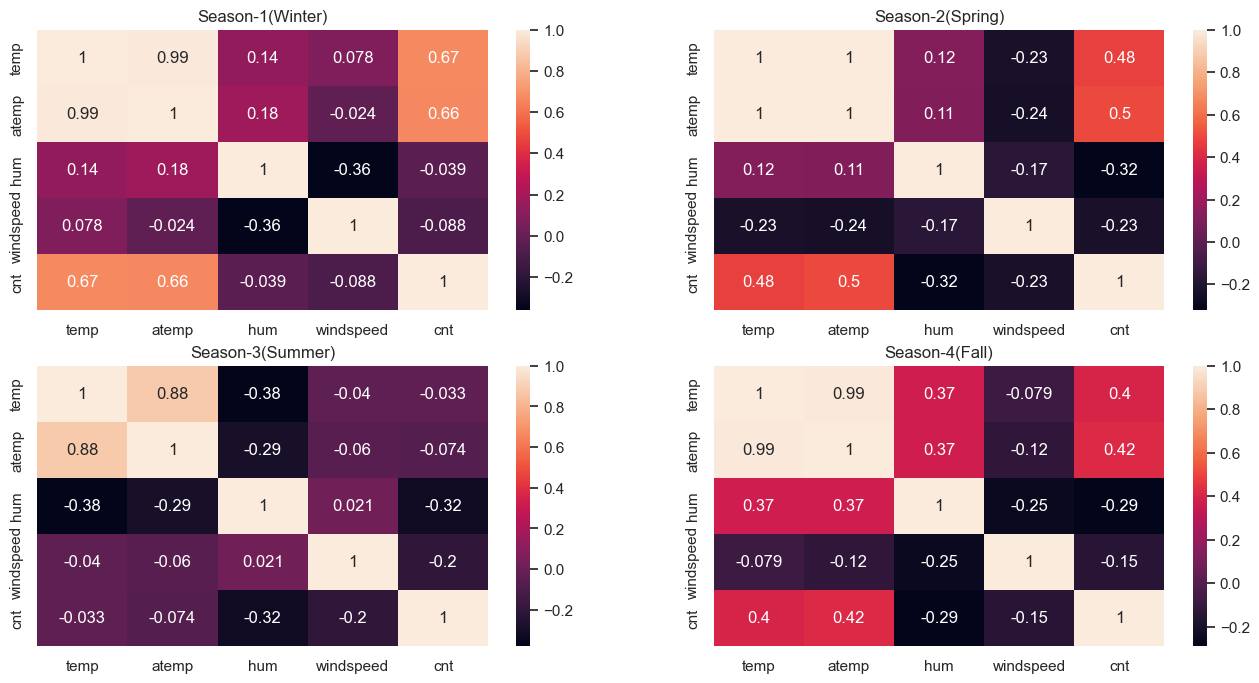

In [258]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
v1 = sns.heatmap(
    df_dcbikes_tidy.loc[
        df_dcbikes_tidy["season"] == 1, ["temp", "atemp", "hum", "windspeed", "cnt"]
    ].corr(),
    annot=True,
    ax=axes[0, 0],
)
v2 = sns.heatmap(
    df_dcbikes_tidy.loc[
        df_dcbikes_tidy["season"] == 2, ["temp", "atemp", "hum", "windspeed", "cnt"]
    ].corr(),
    annot=True,
    ax=axes[0, 1],
)
v3 = sns.heatmap(
    df_dcbikes_tidy.loc[
        df_dcbikes_tidy["season"] == 3, ["temp", "atemp", "hum", "windspeed", "cnt"]
    ].corr(),
    annot=True,
    ax=axes[1, 0],
)
v4 = sns.heatmap(
    df_dcbikes_tidy.loc[
        df_dcbikes_tidy["season"] == 4, ["temp", "atemp", "hum", "windspeed", "cnt"]
    ].corr(),
    annot=True,
    ax=axes[1, 1],
)
v1.set_title("Season-1(Winter)")
v2.set_title("Season-2(Spring)")
v3.set_title("Season-3(Summer)")
v4.set_title("Season-4(Fall)")
plt.show()

#### Regression Model

##### Experiment 1:One Numerical

Regression Equaltion: $bikecounts = {\beta_0} + {\beta_1}*temp+e$

In [259]:
OLS_M1 = custom_statsmodel_OLS(df_eda2, "cnt", "temp")

In [260]:
OLS_M1_fit = OLS_M1.fit()

In [261]:
print(OLS_M1_fit.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.393     
Dependent Variable: cnt              AIC:                12777.5357
Date:               2024-03-29 11:14 BIC:                12786.7245
No. Observations:   731              Log-Likelihood:     -6386.8   
Df Model:           1                F-statistic:        473.5     
Df Residuals:       729              Prob (F-statistic): 2.81e-81  
R-squared:          0.394            Scale:              2.2783e+06
--------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const     1214.6421  161.1635   7.5367  0.0000   898.2421  1531.0421
temp      6640.7100  305.1880  21.7594  0.0000  6041.5577  7239.8623
-------------------------------------------------------------------
Omnibus:              20.477        Durbin-Watson:           

$\hat{bikecounts} = {1214.64} + {6640.71}*\hat{temp}+e$

**Inferences:**

1. The p-value represents the probability of observing a slope as extreme or more extreme as the one we calculated in the sample, assuming there is truly no relationship between X and Y i.e null hypothesis. In our case p-value caluclated for temp is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between temp and counts. 

2. For every increase of 1 unit in temperature, there is an associated increase of, on average, 6640 units of bike counts.

3.  An average of bike counts 1214 when the temp is 0

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.39.

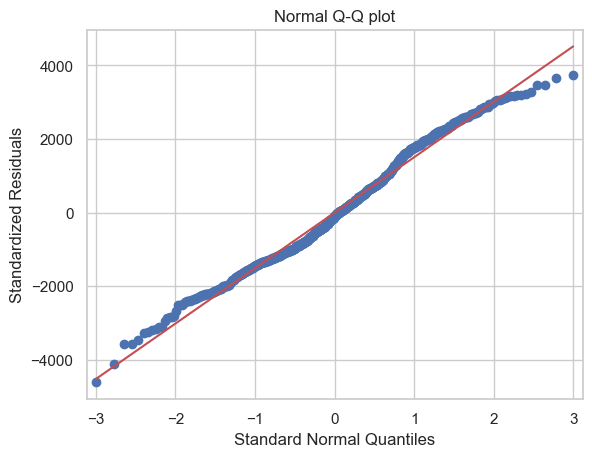

In [262]:
custom_ols_qqplot(OLS_M1_fit.resid)

**Comment**: The Q-Q plot indicates that the residuals are approximately normally distributed.

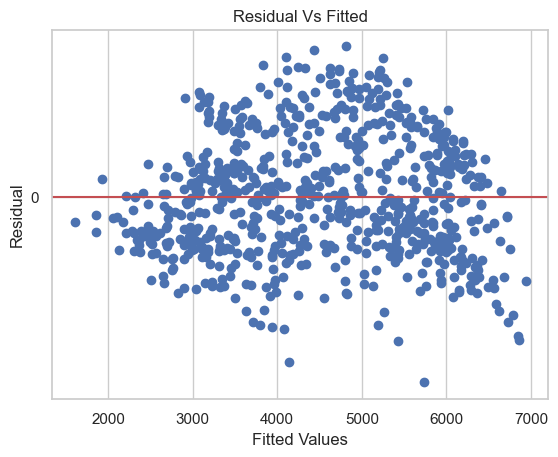

In [263]:
custom_ols_res_vs_fitted(OLS_M1_fit.fittedvalues, OLS_M1_fit.resid)

**Comment**: The fitted vs. residual plot suggests a random scatter of residuals, with no apparent trends.

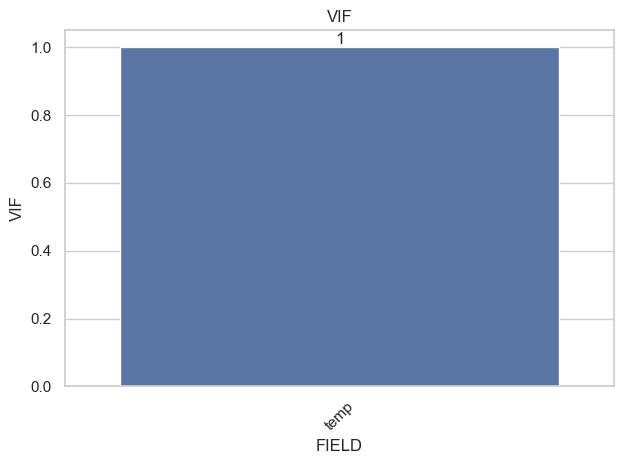

In [264]:
custom_VIF(OLS_M1)

**Comment**: The VIF suggests that temp might have a relatively low collinearity with other independent variables, making it a potentially good choice for exploration.

In [265]:
_new_df = pd.DataFrame({"temp": [0.35, 0.28, 0.34]})
custom_model_preds(OLS_M1_fit, _new_df)

,predicted_y
0,3538.890619
1,3074.040919
2,3472.483519


##### Experiment 2: One numerical and One Categorical

$bikecounts = {\beta_0} + {\beta_1}*temp+{\beta_2}*season2+{\beta_1}*season3+{\beta_1}*season4+e$

In [266]:
df_eda2_encoded = pd.get_dummies(
    df_eda2, columns=["season"], dtype="int", drop_first=True
)

In [267]:
OLS_M2 = custom_statsmodel_OLS(
    df_eda2_encoded, "cnt", "temp", "season_2", "season_3", "season_4"
)

In [268]:
OLS_M2_fit = OLS_M2.fit()

In [269]:
print(OLS_M2_fit.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.453     
Dependent Variable: cnt              AIC:                12704.6549
Date:               2024-03-29 11:14 BIC:                12727.6269
No. Observations:   731              Log-Likelihood:     -6347.3   
Df Model:           4                F-statistic:        152.0     
Df Residuals:       726              Prob (F-statistic): 2.05e-94  
R-squared:          0.456            Scale:              2.0537e+06
--------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const      745.7873  187.4757   3.9780  0.0001   377.7282  1113.8465
temp      6241.3453  518.1419  12.0456  0.0000  5224.1099  7258.5806
season_2   848.7236  197.0817   4.3065  0.0000   461.8056  1235.6416
season_3   490.1956  259.0055   1.8926  0.0588   -18.2936   

$\hat{bikecounts}={745.7873}+6241.34*\hat{temp}+848.72*\hat{season2}+490.19*\hat{season3}+1342.87*\hat{season4}+e$

**Inferences:**
1. P-value caluclated 
     - For temp is 0, we can reject the null in favor of alternate i.e there is a truly relationship between temp and counts. 
     - For season_2 is 0.001, we can reject the null  in favor of alternate i.e there is a truly relationship between Spring season  and bike counts.
     - For season_3 is 0.05, we failed to reject the null i.e there is a truly no relationship between summer season and bike counts.
     - For season_4 is 0.0000, we can reject the null  in favor of alternate i.e there is a truly relationship between Fall season  and bike counts.
     

2. Taking into account all the other explanatory variables in our model, For every increase of 1 unit in temperature, there is an associated increase of, on average, 6241 units of bike counts.

3. Taking into account all the other explanatory variables in our model, 

    - In 'Season2(Spring)' the average number of bike counts 848 units higher on average compared to the Season1(Winter).
    - In 'Season4(Fall)' the average number of bike counts 1342 units higher on average compared to the Season1(Winter).

3. An average of bike counts 745 when all the exploratory variables are zero

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.45.

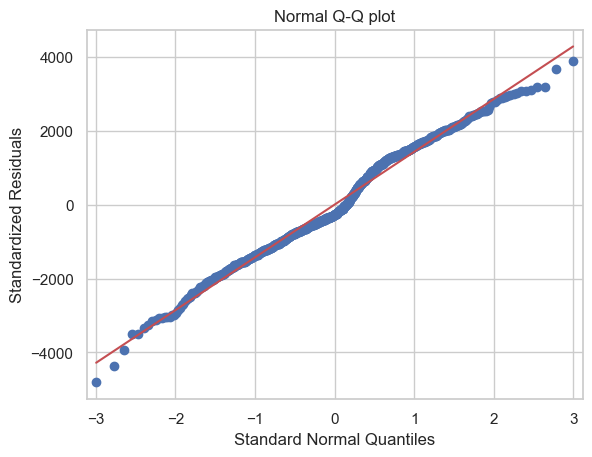

In [270]:
custom_ols_qqplot(OLS_M2_fit.resid)

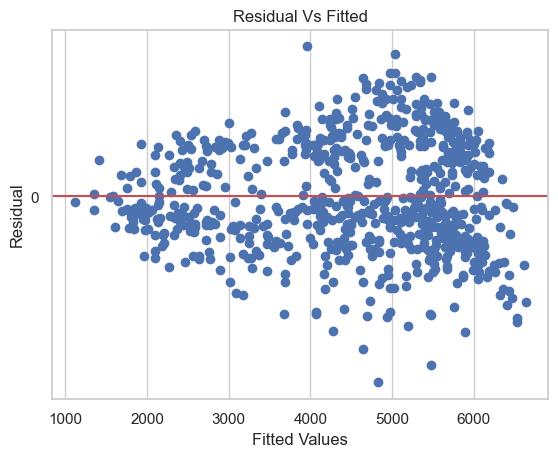

In [271]:
custom_ols_res_vs_fitted(OLS_M2_fit.fittedvalues, OLS_M2_fit.resid)

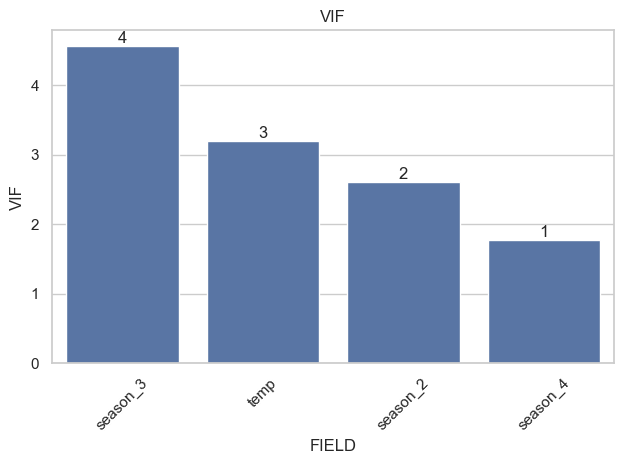

In [272]:
custom_VIF(OLS_M2)

In [273]:
_new_df = df_eda2_encoded.loc[:10, ["temp", "season_2", "season_3", "season_4"]]

In [274]:
custom_model_preds(OLS_M2_fit, _new_df)

,predicted_y
0,2893.852416
1,3014.379035
2,1971.362862
3,1994.056394
4,2162.304338
5,2021.193763
6,1972.348995
7,1775.609309
8,1609.171355
9,1687.188171


#### Experiment 3: More than one numerical: cnt = f(temp, atemp, hum, windspeed)

In [275]:
df_exp_3 = df_dcbikes_tidy[["temp", "atemp", "hum", "windspeed", "cnt"]]

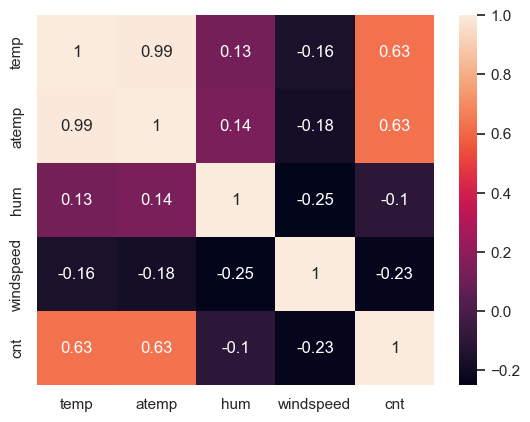

In [276]:
sns.heatmap(df_exp_3.corr(), annot=True)
plt.show()

In [277]:
OLS_M3 = custom_statsmodel_OLS(df_exp_3, "cnt", "temp", "atemp", "hum", "windspeed")

In [278]:
OLS_M3_fit = OLS_M3.fit()

In [279]:
print(OLS_M3_fit.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.461     
Dependent Variable: cnt              AIC:                12693.7344
Date:               2024-03-29 11:14 BIC:                12716.7065
No. Observations:   731              Log-Likelihood:     -6341.9   
Df Model:           4                F-statistic:        157.0     
Df Residuals:       726              Prob (F-statistic): 9.23e-97  
R-squared:          0.464            Scale:              2.0232e+06
-------------------------------------------------------------------
            Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
const      3860.3685  355.3890 10.8624 0.0000  3162.6557  4558.0812
temp       2111.8136 2282.1976  0.9253 0.3551 -2368.6810  6592.3083
atemp      5139.1524 2576.9972  1.9942 0.0465    79.8964 10198.4085
hum       -3149.1098  383.9943 -8.2009 0.0000 -3902.9815 -2395.238

$\hat{bikecounts}={3860.36}+2111.81*\hat{temp}+5139*\hat{atemp}+(-3149.10)*\hat{hum}+(-4528.67)*\hat{windspeed}+e$

**Inferences**
1. P-value caluclated 
     - For temp is 30, we failed to reject the null in favor of alternate i.e there is NO truly relationship between temp and counts. 
     - For atemp is 0.04, we can reject the null  in favor of alternate i.e there is a truly relationship between atemp  and bike counts.
     - For hum is 0.05, we can reject the null i.e there is a truly relationship between humidity and bike counts.
     - For windspeed is 0.0000, we can reject the null  in favor of alternate i.e there is a truly relationship between windspeed  and bike counts.
     
     
2. Taking into account all the other explanatory variables in our model, 
    - for every increase of one unit in temperature, there is an associated increase of on average 2111 in bike counts.
    - for every increase of one unit in atemperature, there is an associated increase of on average 5139 in bike counts.
    - for every increase of one unit in humidity, there is an associated decrease of on average 3149 in bike counts.
    - for every increase of one unit in windpspeed, there is an associated decreased of on average 4528 in bike counts.

3. An average of bike counts 3860 when all the exploratory variables are zero

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.46.

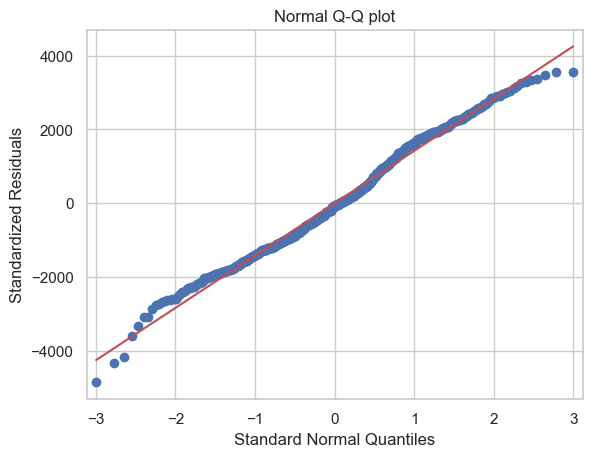

In [280]:
custom_ols_qqplot(OLS_M3_fit.resid)

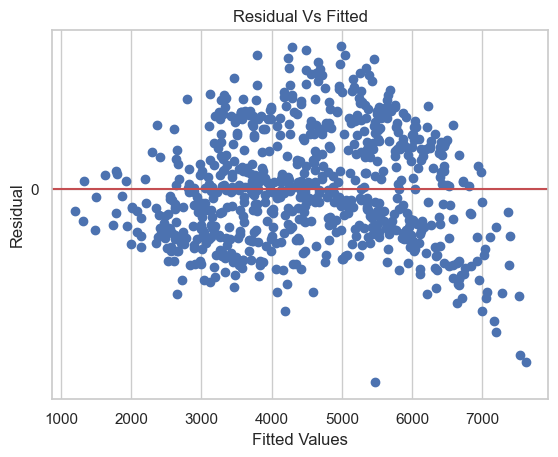

In [281]:
custom_ols_res_vs_fitted(OLS_M3_fit.fittedvalues, OLS_M3_fit.resid)

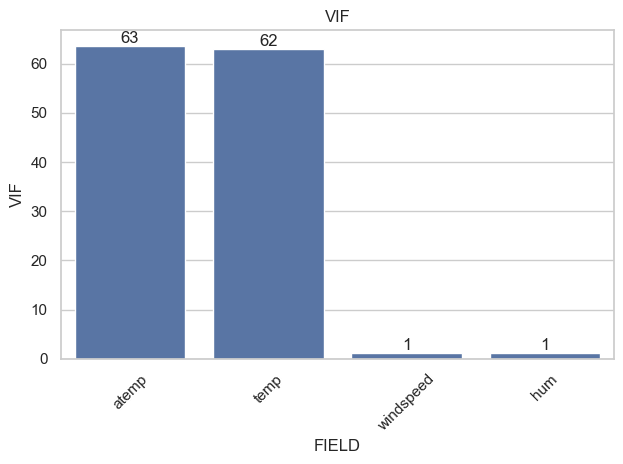

In [282]:
custom_VIF(OLS_M3)

### Case 2: Auto

#### Data Importing, Prep and EDA

In [283]:
df_auto = pd.read_csv(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/auto.csv"
)

In [284]:
df_auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


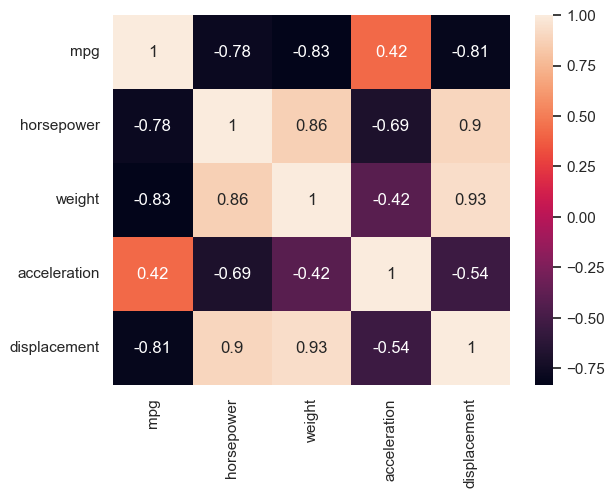

In [285]:
sns.heatmap(
    df_auto[["mpg", "horsepower", "weight", "acceleration", "displacement"]].corr(),
    annot=True,
)
plt.show()

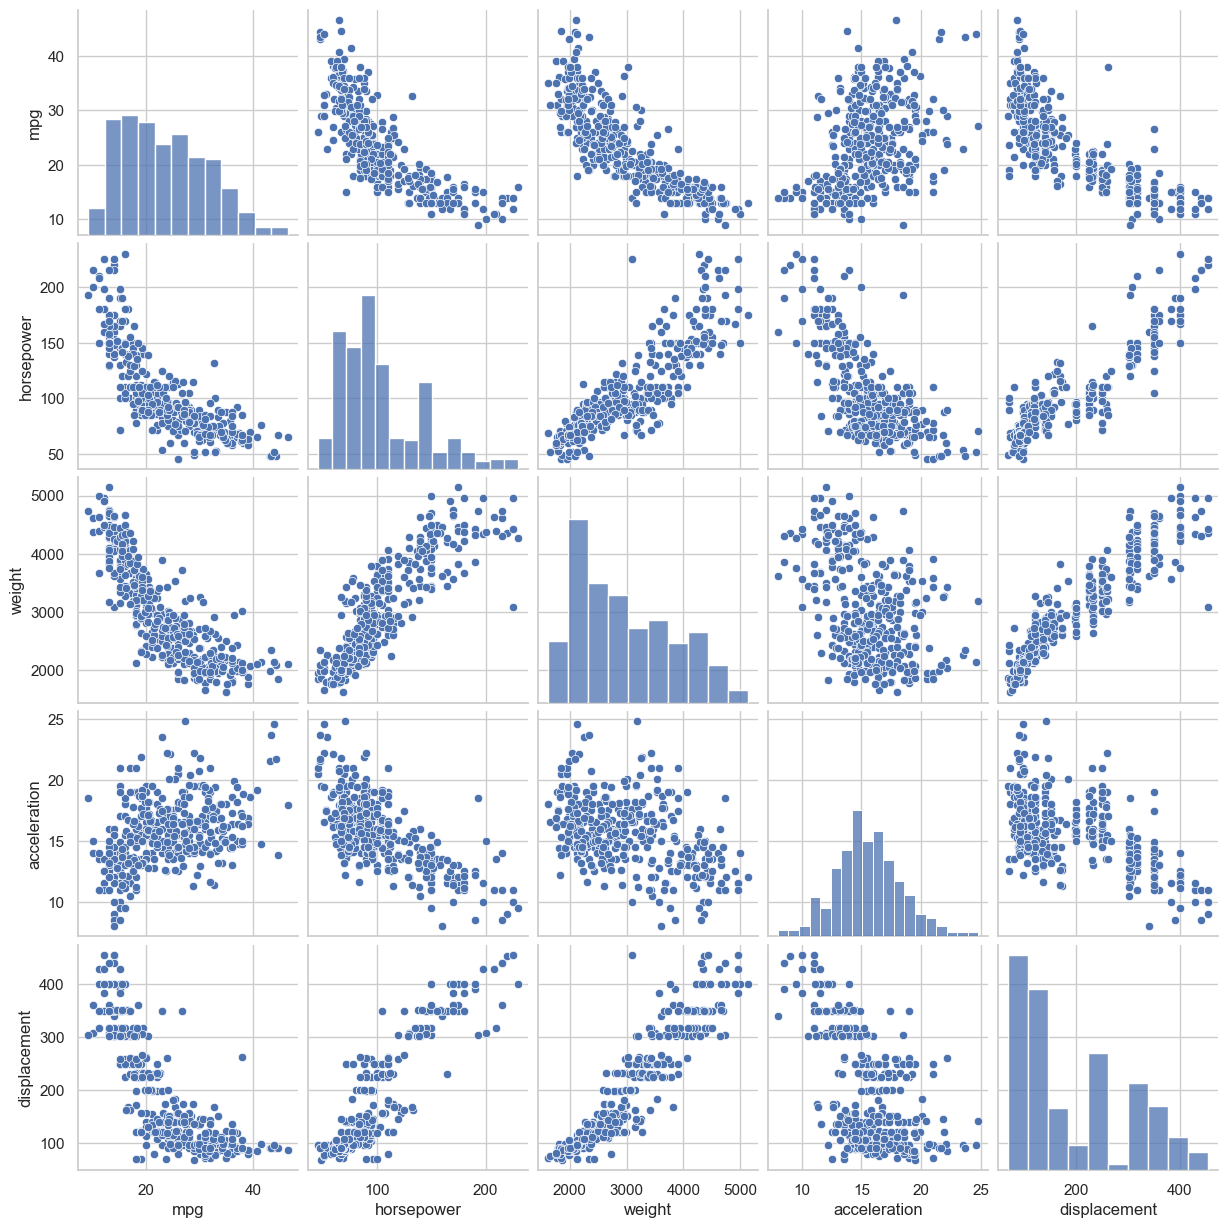

In [286]:
sns.pairplot(df_auto[["mpg", "horsepower", "weight", "acceleration", "displacement"]])
plt.show()

#### Regression Model

#### Experiment 1: One Numerical: mpg=f(horsepower)

In [287]:
SL1 = custom_statsmodel_OLS(df_auto, "mpg", "horsepower")

In [288]:
SL1_modelfit = SL1.fit()

In [289]:
print(SL1_modelfit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.605    
Dependent Variable: mpg              AIC:                2361.3237
Date:               2024-03-29 11:15 BIC:                2369.2662
No. Observations:   392              Log-Likelihood:     -1178.7  
Df Model:           1                F-statistic:        599.7    
Df Residuals:       390              Prob (F-statistic): 7.03e-81 
R-squared:          0.606            Scale:              24.066   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const         39.9359    0.7175   55.6598  0.0000  38.5252  41.3465
horsepower    -0.1578    0.0064  -24.4891  0.0000  -0.1705  -0.1452
------------------------------------------------------------------
Omnibus:               16.432       Durbin-Watson:          0.920 
Prob(Omn

$\hat{mpg}={39.9359}+(-0.15)*\hat{horsepower}+e$

**Inferences:**

1. In our case p-value caluclated for HorsePower is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between Horsepower and MPG. 

2. For every increase of 1 unit in HorsePower, there is an associated decrease of, on average, 0.15 units of MPG.

3.  An average of MPG is 39 when the Horsepower is 0

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.60

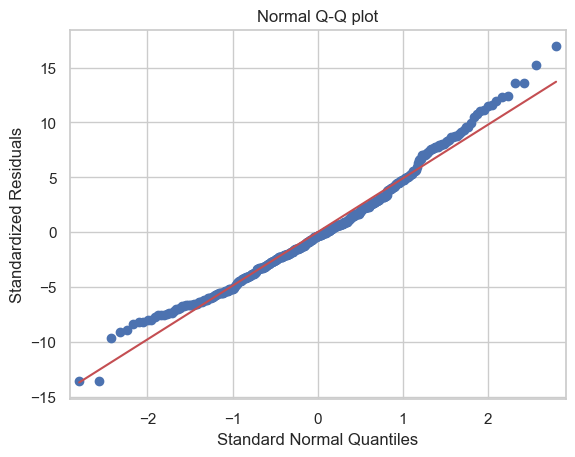

In [290]:
custom_ols_qqplot(SL1_modelfit.resid)

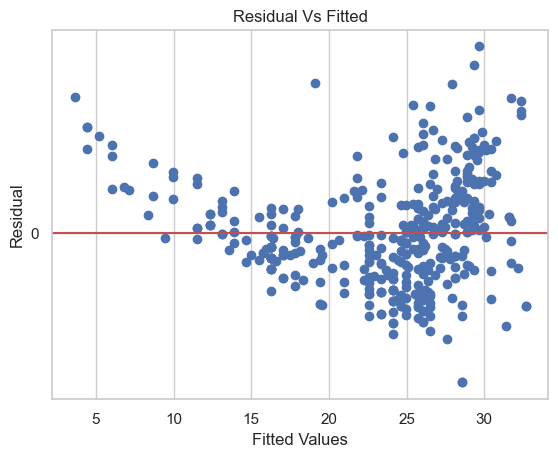

In [291]:
custom_ols_res_vs_fitted(SL1_modelfit.fittedvalues, SL1_modelfit.resid)

#### Experiment2: two numericals: mpg=f(horsepower,acceleration)

In [292]:
SL2 = custom_statsmodel_OLS(df_auto, "mpg", "horsepower", "acceleration")

In [293]:
SL2_modelfit = SL2.fit()

In [294]:
print(SL2_modelfit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.628    
Dependent Variable: mpg              AIC:                2338.2770
Date:               2024-03-29 11:15 BIC:                2350.1908
No. Observations:   392              Log-Likelihood:     -1166.1  
Df Model:           2                F-statistic:        331.7    
Df Residuals:       389              Prob (F-statistic): 8.67e-85 
R-squared:          0.630            Scale:              22.635   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const         52.5593    2.5870   20.3164  0.0000  47.4730  57.6457
horsepower    -0.1880    0.0086  -21.7883  0.0000  -0.2049  -0.1710
acceleration  -0.6098    0.1204   -5.0662  0.0000  -0.8464  -0.3731
------------------------------------------------------------------
Omnibus

$\hat{mpg}={52.5593}+(-0.18)*\hat{horsepower}+(-0.60)*\hat{acceleration}+e$

**Inferences:**

1. p-value caluclated 
     - for HorsePower is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between Horsepower and MPG. 
     - for Accelaration is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between Accelaration and MPG.

2. For every increase of 1 unit in HorsePower, there is an associated decrease of, on average, 0.18 units of MPG.

3. For every increase of 1 unit in Accelaration, there is an associated decrease of, on average, 0.6 units of MPG.

4.  An average of MPG is 52 when the Horsepower is 0

5. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.62

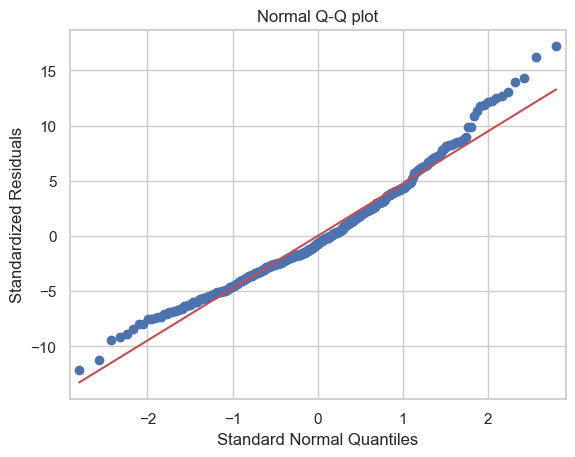

In [295]:
custom_ols_qqplot(SL2_modelfit.resid)

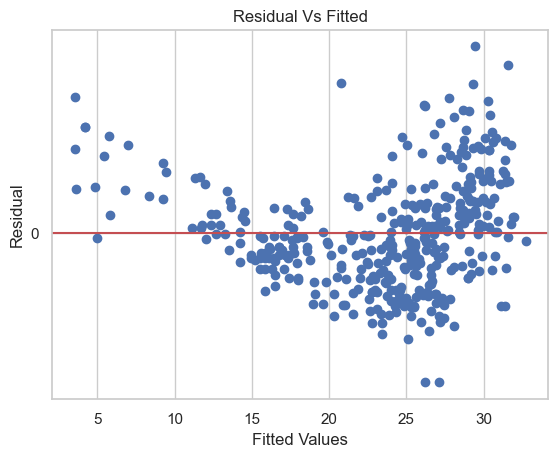

In [296]:
custom_ols_res_vs_fitted(SL2_modelfit.fittedvalues, SL1_modelfit.resid)

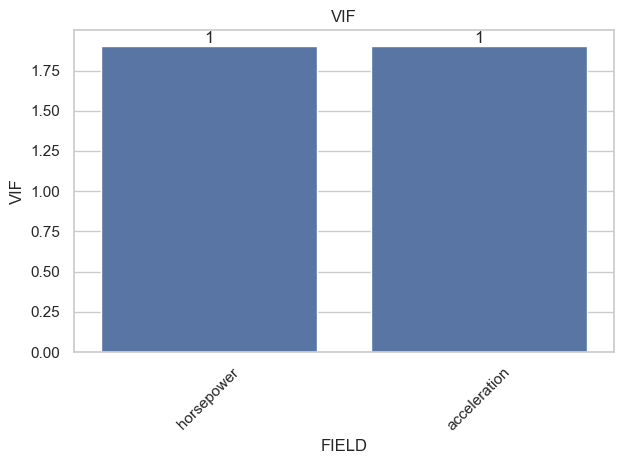

In [297]:
custom_VIF(SL2)

#### Experiment3: More than 2 numericals: mpg=f("horsepower", "weight", "acceleration", "displacement")

In [298]:
SL3 = custom_statsmodel_OLS(
    df_auto, "mpg", "horsepower", "weight", "acceleration", "displacement"
)

In [299]:
SL3_modelfit = SL3.fit()

In [300]:
print(SL3_modelfit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.704    
Dependent Variable: mpg              AIC:                2251.1955
Date:               2024-03-29 11:15 BIC:                2271.0518
No. Observations:   392              Log-Likelihood:     -1120.6  
Df Model:           4                F-statistic:        233.4    
Df Residuals:       387              Prob (F-statistic): 9.63e-102
R-squared:          0.707            Scale:              18.035   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          45.2511    2.4560  18.4244  0.0000  40.4223  50.0800
horsepower     -0.0436    0.0166  -2.6312  0.0088  -0.0762  -0.0110
weight         -0.0053    0.0008  -6.5123  0.0000  -0.0069  -0.0037
acceleration   -0.0231    0.1256  -0.1843  0.8539  -0.2701   0.2238
displa

$\hat{mpg}={45.2511}+(-0.04)*\hat{horsepower}+(0.0053)*\hat{weight}+(0.0231)*\hat{acceleration}+(-0.0060)*\hat{displacement}+e$

**Inferences:**

1. p-value caluclated 
     - for HorsePower is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between Horsepower and MPG. 
     - for Weight is 0 hence we can reject the null in favor of alternate i.e there is a truly relationship between Weight and MPG.
     - for Accelaration is 0.85 we fail to reject the null i.e there is NO truly relationship between Accelaration and MPG. 
     - for Displacement is 0.37 we fail to reject the null i.e there is NO truly relationship between Displacement and MPG.

2. For every increase of 1 unit in HorsePower, there is an associated decrease of, on average, 0.04 units of MPG.

3. For every increase of 1 unit in weight, there is an associated decrease of, on average, 0.005 units of MPG.

4.  An average of MPG is 45.25 when the Horsepower is 0

5. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.704

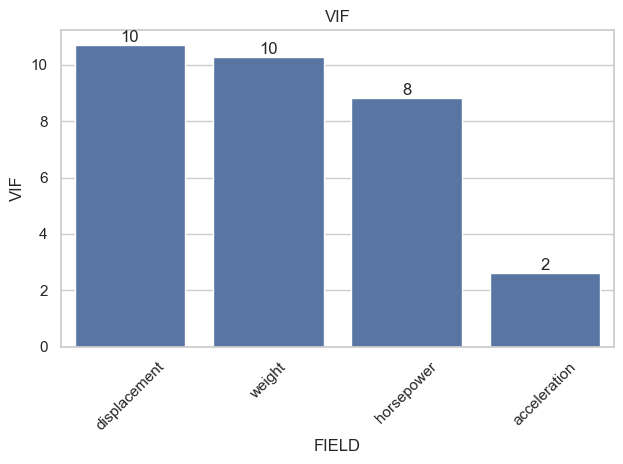

In [301]:
custom_VIF(SL3)

### Case 3: CarSeats

#### Data Importing and Prep

In [302]:
df_carseats = pd.read_csv(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/carseats.csv"
)

In [303]:
df_carseats = pd.get_dummies(
    df_carseats, columns=["ShelveLoc", "Urban", "US"], dtype="int", drop_first=True
)

In [304]:
df_carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,0,0,1,1
1,11.22,111,48,16,260,83,65,10,1,0,1,1
2,10.06,113,35,10,269,80,59,12,0,1,1,1
3,7.40,117,100,4,466,97,55,14,0,1,1,1
4,4.15,141,64,3,340,128,38,13,0,0,1,0


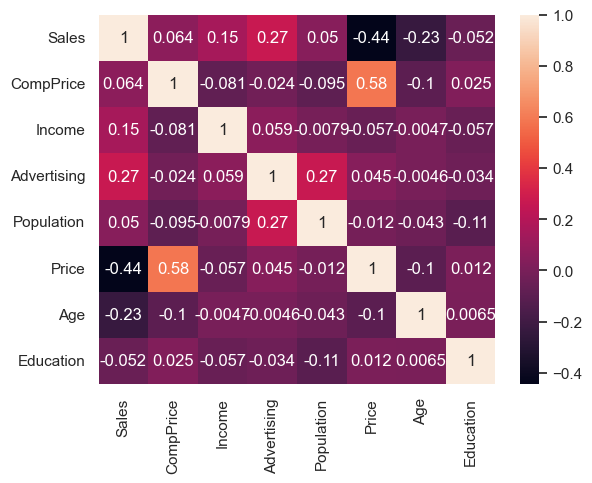

In [305]:
sns.heatmap(
    df_carseats[
        [
            "Sales",
            "CompPrice",
            "Income",
            "Advertising",
            "Population",
            "Price",
            "Age",
            "Education",
        ]
    ].corr(),
    annot=True,
)
plt.show()

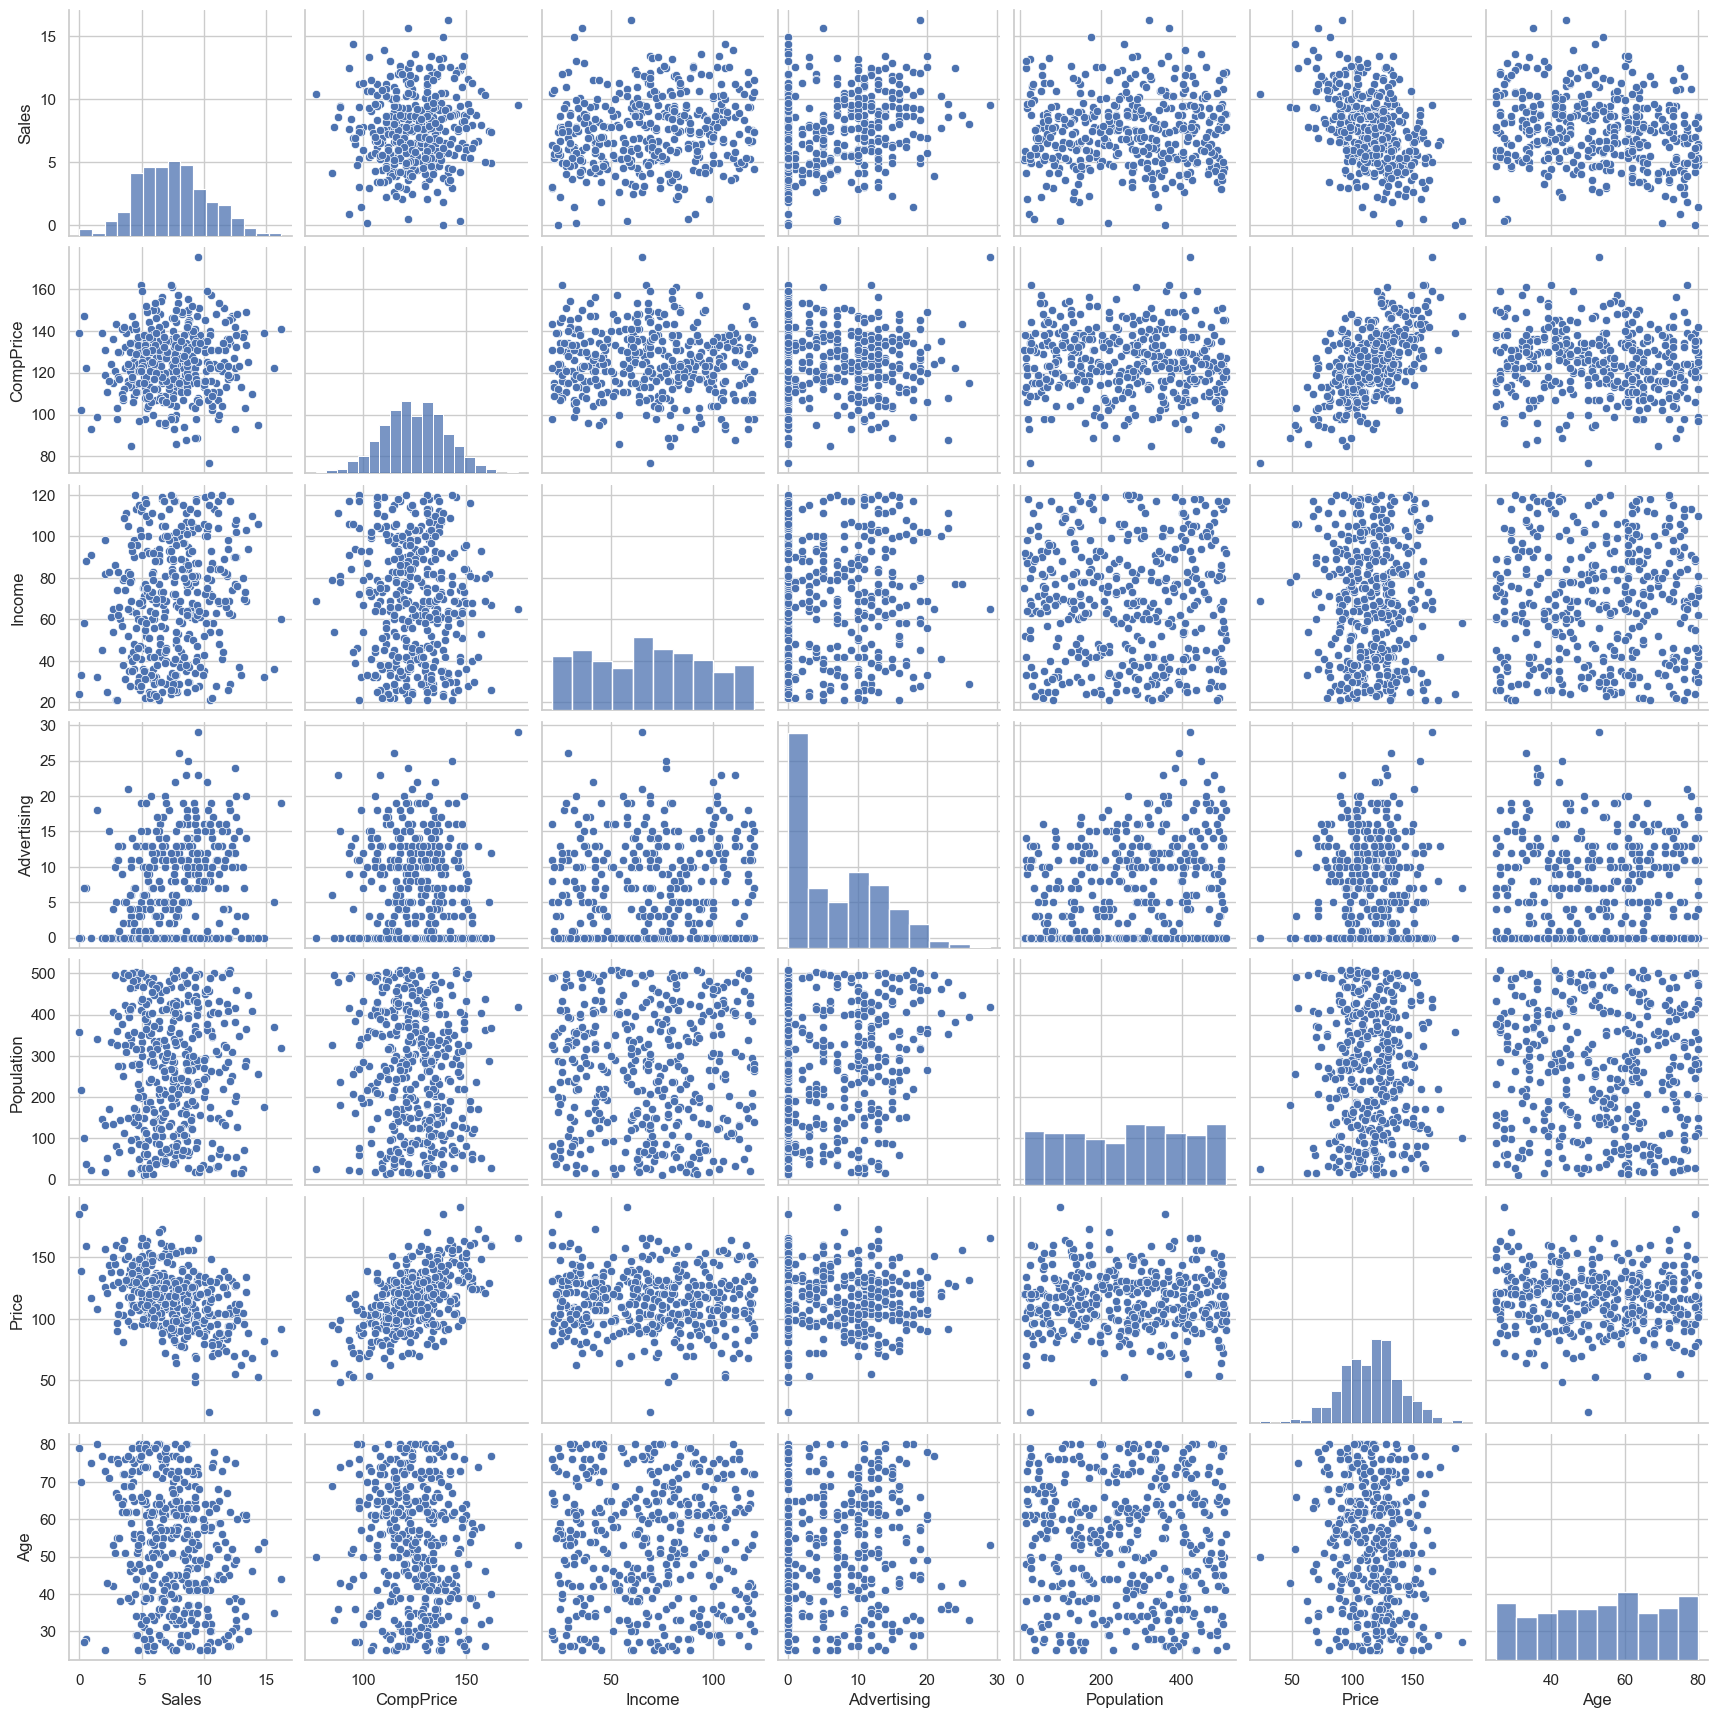

In [306]:
sns.pairplot(
    df_carseats[
        ["Sales", "CompPrice", "Income", "Advertising", "Population", "Price", "Age"]
    ]
)
plt.show()

#### Regression Model

#### Experiment 1: More than 1 Numericals: Sales=f("CompPrice","Income","Advertising","Population","Price","Age","Education")

In [307]:
car_SL1 = custom_statsmodel_OLS(
    df_carseats,
    "Sales",
    "CompPrice",
    "Income",
    "Advertising",
    "Population",
    "Price",
    "Age",
    "Education",
)

In [308]:
car_SL1_fit = car_SL1.fit()

In [309]:
print(car_SL1_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.533    
Dependent Variable: Sales            AIC:                1668.6475
Date:               2024-03-29 11:15 BIC:                1700.5792
No. Observations:   400              Log-Likelihood:     -826.32  
Df Model:           7                F-statistic:        66.18    
Df Residuals:       392              Prob (F-statistic): 1.41e-62 
R-squared:          0.542            Scale:              3.7208   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          7.7077    1.1176    6.8965  0.0000   5.5104   9.9050
CompPrice      0.0939    0.0078   11.9797  0.0000   0.0785   0.1093
Income         0.0129    0.0035    3.7034  0.0002   0.0060   0.0197
Advertising    0.1309    0.0151    8.6539  0.0000   0.1011   0.1606
Popula

**Inferences**
1. P-value caluclated 
     - For CompPrice is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between ComPrice and Sales. 
     - For Income is 0.00, we can reject the null  in favor of alternate i.e there is a truly relationship between Income and Sales. 
     - For Advertising is 0.0002, we can reject the null i.e there is a truly relationship between Advertising and Sales. 
     - For Price is 0.00, we can reject the null i.e there is a truly relationship between Price and Sales. 
     - For Age is 0.00, we can reject the null i.e there is a truly relationship between Age and Sales. 
     - For Education is 0.28, we fail to reject the null i.e there is NO truly relationship between Education and Sales. 
     - For Population is 0.85, we fail to reject the null i.e there is NO truly relationship between Population and Sales.
     
     
2. Taking into account all the other explanatory variables in our model, 
    - for every increase of one unit in CompPrice, there is an associated increase of on average 0.09 in Sales
    - for every increase of one unit in Income, there is an associated increase of on average 0.01 in Sales
    - for every increase of one unit in Advertising, there is an associated increase of on average 0.13 in Sales.
    - for every increase of one unit in Price, there is an associated decreased of on average 0.09 in Sales.
    - for every increase of one unit in Age, there is an associated decreased of on average 0.04 in Sales.

3. An average of Sales 7.7 when all the exploratory variables are zero

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.53

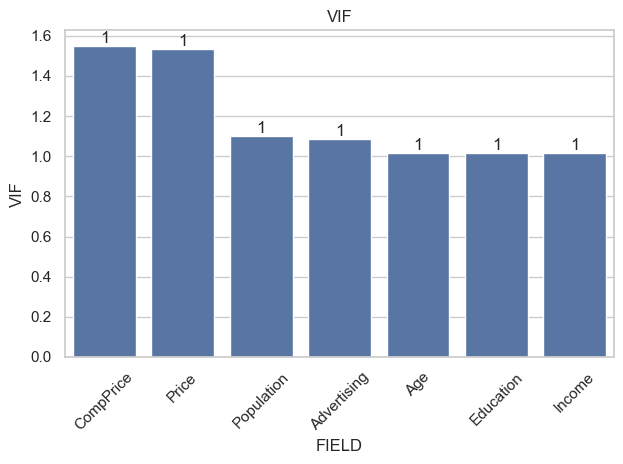

In [310]:
custom_VIF(car_SL1)

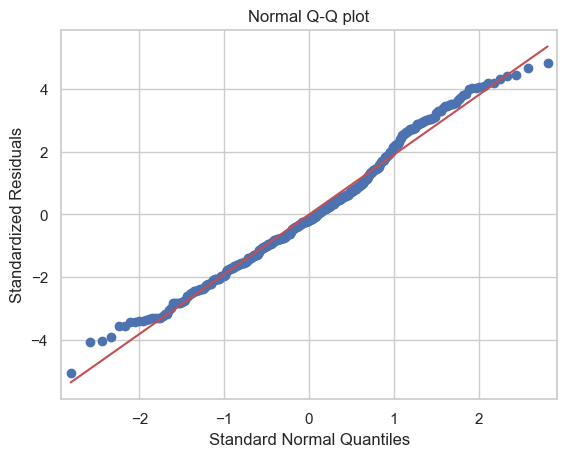

In [311]:
custom_ols_qqplot(car_SL1_fit.resid)

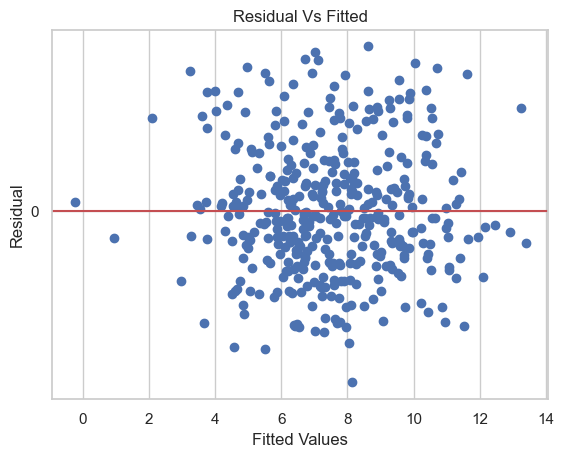

In [312]:
custom_ols_res_vs_fitted(car_SL1_fit.fittedvalues, car_SL1_fit.resid)

#### Experiment 2: More than 1 Numericals and Categorical: Sales=f("CompPrice","Income","Advertising","Population","Price","Age","Education","ShelveLoc_Good","ShelveLoc_Medium","Urban_Yes","US_Yes")

In [313]:
car_SL2 = custom_statsmodel_OLS(
    df_carseats,
    "Sales",
    "CompPrice",
    "Income",
    "Advertising",
    "Population",
    "Price",
    "Age",
    "Education",
    "ShelveLoc_Good",
    "ShelveLoc_Medium",
    "Urban_Yes",
    "US_Yes",
)

In [314]:
car_SL2_fit = car_SL2.fit()

In [315]:
print(car_SL2_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.870    
Dependent Variable: Sales            AIC:                1161.9744
Date:               2024-03-29 11:15 BIC:                1209.8719
No. Observations:   400              Log-Likelihood:     -568.99  
Df Model:           11               F-statistic:        243.4    
Df Residuals:       388              Prob (F-statistic): 1.60e-166
R-squared:          0.873            Scale:              1.0382   
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              5.6606   0.6034   9.3805 0.0000  4.4742  6.8471
CompPrice          0.0928   0.0041  22.3778 0.0000  0.0847  0.1010
Income             0.0158   0.0018   8.5647 0.0000  0.0122  0.0194
Advertising        0.1231   0.0111  11.0660 0.0000  0.1012  0.1450
Population   

**Inferences**
1. P-value caluclated 
     - For CompPrice is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between ComPrice and Sales. 
     - For Income is 0.00, we can reject the null  in favor of alternate i.e there is a truly relationship between Income and Sales. 
     - For Advertising is 0.00, we can reject the null i.e there is a truly relationship between Advertising and Sales. 
     - For Price is 0.00, we can reject the null i.e there is a truly relationship between Price and Sales. 
     - For Age is 0.00, we can reject the null i.e there is a truly relationship between Age and Sales. 
     - For Education is 0.28, we fail to reject the null i.e there is NO truly relationship between Education and Sales. 
     - For Population is 0.85, we fail to reject the null i.e there is NO truly relationship between Population and Sales.
     - For Uran Yes, we fail to reject the null i.e there is NO truly relationship between Urban and Sales.
     - For US Yes, we fail to reject the null i.e there is NO truly relationship between US and Sales.
     
     
2. Taking into account all the other explanatory variables in our model, 
    - for every increase of one unit in CompPrice, there is an associated increase of on average 0.09 in Sales
    - for every increase of one unit in Income, there is an associated increase of on average 0.01 in Sales
    - for every increase of one unit in Advertising, there is an associated increase of on average 0.12 in Sales.
    - for every increase of one unit in Price, there is an associated decreased of on average 0.09 in Sales.
    - for every increase of one unit in Age, there is an associated decreased of on average 0.04 in Sales.
    - For ShelveLoc_Good the average number of Sales 4.85 units higher on average compared to the ShelveLoc_Bad
    - For ShelveLoc_Medium the average number of Sales 1.95 units higher on average compared to the ShelveLoc_Bad
    
3. An average of Sales 5.6 when all the exploratory variables are zero

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.87

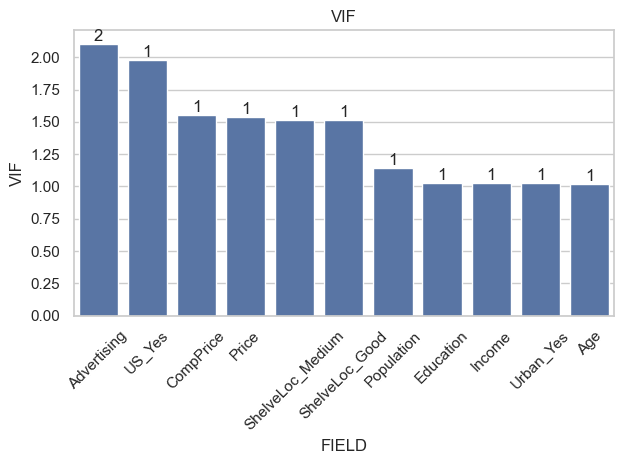

In [316]:
custom_VIF(car_SL2)

### Case 4: BodyFat

#### Data Importing and Prep

In [317]:
df_bodyfat = pd.read_csv(
    r"/Users/malleshamyamulla/Desktop/SSBBA/assignments/w4/data/bodyfat.csv"
)

In [318]:
df_bodyfat.head()

,Density,Age,Weight,Height,ADI,FFW,Neck,Chest,ADC,Hip,Thigh,Knee,Ankle,EBC,FC,WC,Body Fat
0,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6
1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9
2,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6
3,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9
4,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8


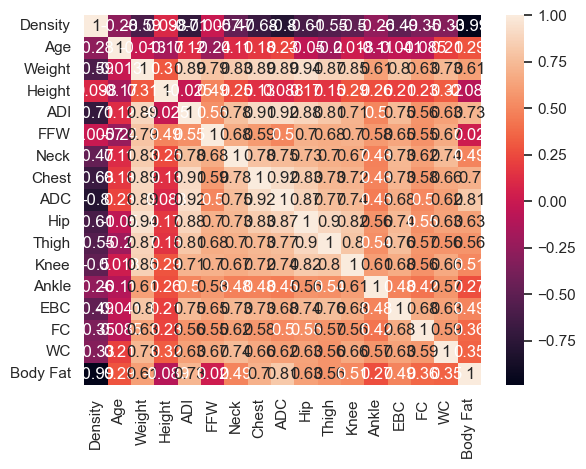

In [319]:
sns.heatmap(df_bodyfat.corr(), annot=True)
plt.show()

#### Regression Model

#### Experiment 1:

In [320]:
body_fat_SL = custom_statsmodel_OLS(
    df_bodyfat,
    "Body Fat",
    "Density",
    "Age",
    "Weight",
    "Height",
    "ADI",
    "FFW",
    "Neck",
    "Chest",
    "ADC",
    "Hip",
    "Thigh",
    "Knee",
    "Ankle",
    "EBC",
    "FC",
    "WC",
)

In [321]:
body_fat_SL_fit = body_fat_SL.fit()

In [322]:
print(body_fat_SL_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.986    
Dependent Variable: Body Fat         AIC:                680.7642 
Date:               2024-03-29 11:15 BIC:                740.7645 
No. Observations:   252              Log-Likelihood:     -323.38  
Df Model:           16               F-statistic:        1138.    
Df Residuals:       235              Prob (F-statistic): 1.62e-212
R-squared:          0.987            Scale:              0.81750  
------------------------------------------------------------------
              Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------
const        253.2587  15.2445  16.6132 0.0000  223.2255  283.2920
Density     -234.0972  13.1352 -17.8221 0.0000 -259.9750 -208.2193
Age            0.0057   0.0068   0.8377 0.4030   -0.0077    0.0192
Weight         0.1594   0.0164   9.7451 0.0000    0.1272    0.1916
Height       

**Inferences**
1. P-value caluclated 
     - For Density is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between Density and Body Fat
     - For Weight is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between Weight and Body Fat
     - For ADI is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between ADI and Body Fat
     - For Chest is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between Chest and Body Fat
     - For Density is 0.00, we can reject the null in favor of alternate i.e there is a truly relationship between Density and Body Fat
     - For Thigh is 0.02, we can reject the null in favor of alternate i.e there is a truly relationship between Thigh and Body Fat
     - For the independent variables: Age,Height,Neck,ADC,Hip,Knee,Ankle,EBC,and WC are having more p-value i.e >0.05, hence we failed to raject the null i.e there is NO true relationship between these variabels and body fat
     
     
2. Taking into account all the other explanatory variables in our model,

    - for every increase of one unit in Weight, there is an associated increase of on average 0.15 in Body Fat
    
3. An average of Body Fat 253 when all the exploratory variables are zero

4. The proportion of variability in the outcome variable i.e bike count explained by this model is about 0.98

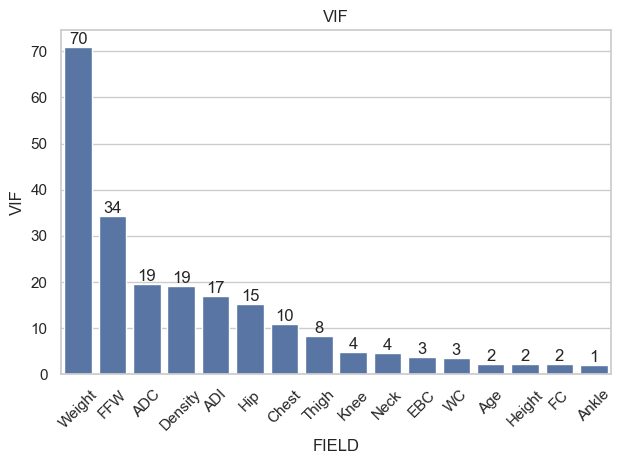

In [323]:
custom_VIF(body_fat_SL)

In [324]:
df_bodyfat_sel = df_bodyfat[
    ["Knee", "Neck", "EBC", "WC", "Age", "Height", "FC", "Ankle", "Body Fat"]
]

In [325]:
body_fat_SL_2 = custom_statsmodel_OLS(
    df_bodyfat_sel,
    "Body Fat",
    "Knee",
    "Neck",
    "EBC",
    "WC",
    "Age",
    "Height",
    "FC",
    "Ankle",
)

In [326]:
body_fat_SL_2_fit = body_fat_SL_2.fit()

In [327]:
print(body_fat_SL_2_fit.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.442    
Dependent Variable: Body Fat         AIC:                1609.1443
Date:               2024-03-29 11:15 BIC:                1640.9092
No. Observations:   252              Log-Likelihood:     -795.57  
Df Model:           8                F-statistic:        25.83    
Df Residuals:       243              Prob (F-statistic): 1.05e-28 
R-squared:          0.460            Scale:              33.534   
--------------------------------------------------------------------
          Coef.     Std.Err.      t      P>|t|     [0.025     0.975]
--------------------------------------------------------------------
const    -23.6281     9.1181   -2.5913   0.0101   -41.5887   -5.6674
Knee       1.1799     0.2454    4.8071   0.0000     0.6964    1.6634
Neck       0.7565     0.2681    2.8217   0.0052     0.2284    1.2846
EBC        0.6198     0.2074    2.9889   0.0031     0.2113    1.0282

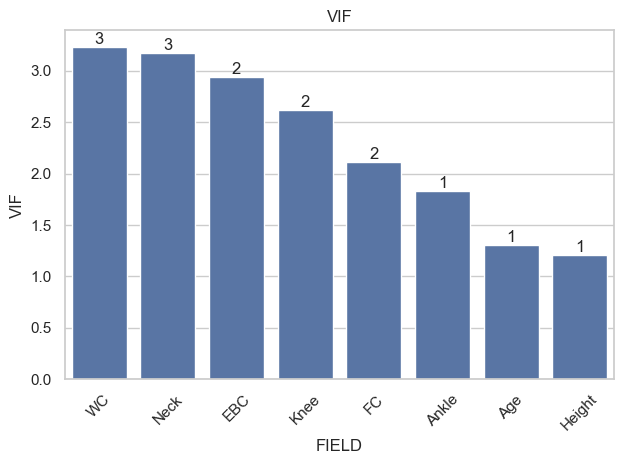

In [328]:
custom_VIF(body_fat_SL_2)

# END